In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.cluster import Decahedron

[AirtilhndeJacob.home:15058] shmem: mmap: an error occurred while determining whether or not /var/folders/9y/xthk6v1524d_wtrmdw87dt7c0000gn/T//ompi.AirtilhndeJacob.501/jf.0/2339766272/sm_segment.AirtilhndeJacob.501.8b760000.0 could be created.


(examples:prism_quickstart)=
# PRISM quickstart

This is a short example of running a STEM simulation of a supported nanoparticle with the PRISM algorithm. See our [tutorial](tutorials:prism) for a more in depth description.  

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [2]:
abtem.config.set(
    {
        "device": "cpu",
        "fft": "numpy",
        "diagnostics.task_progress": True,
        "diagnostics.progress_bar": "tqdm",
    }
)

## Atomic model

We create an atomic model of a decahedral copper nanoparticle. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

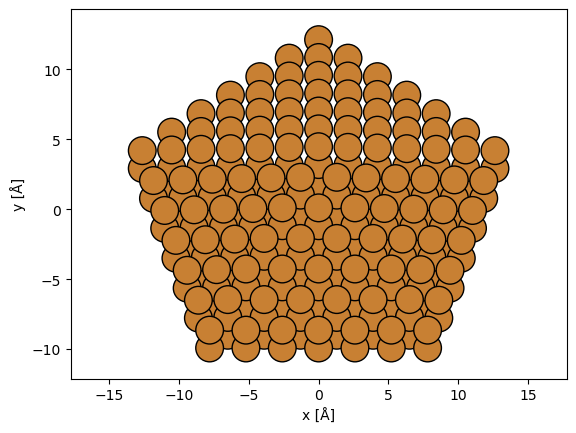

In [3]:
cluster = Decahedron("Cu", 7, 2, 0)
cluster.rotate("x", 30)

abtem.show_atoms(cluster, plane="xy");

A rough model of amorphous carbon is created by randomly displacing the atoms of a diamond structure

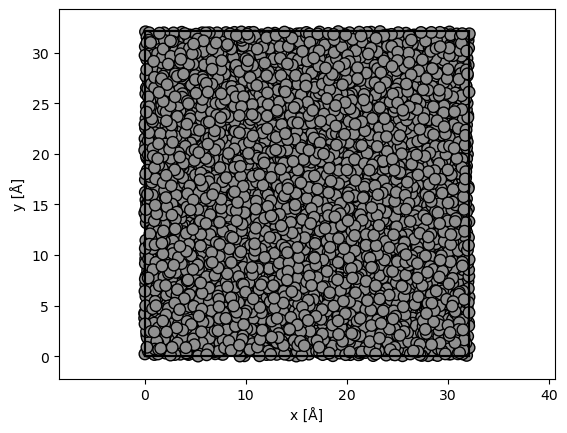

In [4]:
substrate = ase.build.bulk("C", cubic=True)

# repeat diamond structure
substrate = substrate * (9, 9, 20)

# displace atoms with a standard deviation of 50 % of the bond length
bondlength = 1.54  # Bond length
substrate.positions[:] += np.random.randn(len(substrate), 3) * 0.5 * bondlength

# wrap the atoms displaced outside the cell back into the cell
substrate.wrap()

abtem.show_atoms(substrate, plane="xy", merge=0.5);

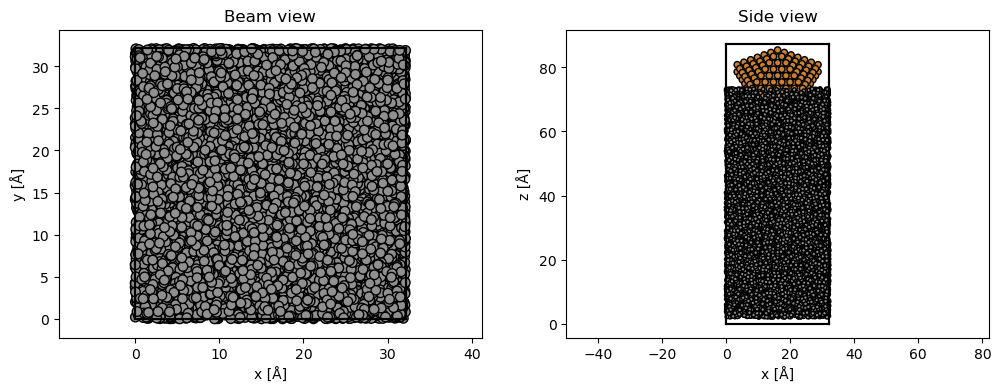

In [5]:
translated_cluster = cluster.copy()

translated_cluster.cell = substrate.cell
translated_cluster.center()
translated_cluster.translate((0, 0, 40))

atoms = substrate + translated_cluster

atoms.center(axis=2, vacuum=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, plane="xy", ax=ax1, title="Beam view")
abtem.show_atoms(atoms, plane="xz", ax=ax2, title="Side view");

## Potential

We create an ensemble of potentials using the frozen phonon model. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [6]:
frozen_phonons = abtem.FrozenPhonons(atoms, 4, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [7]:
potential = abtem.Potential(
    frozen_phonons,
    gpts=512,
    slice_thickness=2,
)

## SMatrix

We create the ensemble of SMatrices by providing our potential, an acceleration voltage $200 \ \mathrm{keV}$, a cutoff of the plane wave expansion of the probe of $20 \ \mathrm{mrad}$ and an interpolation factor of 4 in both $x$ and $y$. See our [tutorial on PRISM](tutorials:prism)

In [8]:
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=100e3,
    semiangle_cutoff=20,
    interpolation=4,
    downsample=True,
)

s_matrix.shape

(4, 69, 512, 512)

## Contrast transfer function

To include defocus, spherical aberration and other phase aberrations, we should define a contrast transfer function. Here we create one with a spherical aberration of $8 \ \mu m$, the defocus is adjusted to the according Scherzer defocus.

In [9]:
Cs = 8e-6 * 1e10  # 8 micrometers

ctf = abtem.CTF(Cs=0, defocus=[0, 80], energy=s_matrix.energy)

We always ensure that the interpolation factor is sufficiently small to avoid self-interaction errors. We can check that by showing the equivalent probe at the entrance and exit plane.

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

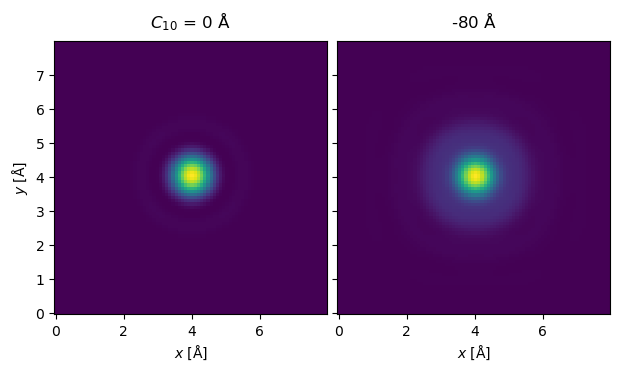

In [10]:
s_matrix.dummy_probes(ctf=ctf).show(explode=True)

We should also check that our real space sampling is good enough for detecting electrons at our desired detector angles. In this case up to $\sim 200 \ \mathrm{mrad}$. See our [description of sampling](appendix:antialiasing).

In [11]:
s_matrix.cutoff_angles

(196.99522495070337, 196.99522495070337)

## Create a detector and a scan

In [23]:
detectors = abtem.FlexibleAnnularDetector()

In [25]:
flexible_measurement = s_matrix.scan(
    detectors=detectors, ctf=ctf, reduction_scheme="no-chunks"
)

In [26]:
flexible_measurement.compute()

tasks:   0%|          | 0/35 [00:00<?, ?it/s]

multislice:   0%|          | 0/352 [00:00<?, ?it/s]

multislice:   0%|          | 0/352 [00:00<?, ?it/s]

multislice:   0%|          | 0/352 [00:00<?, ?it/s]

multislice:   0%|          | 0/352 [00:00<?, ?it/s]

multislice:   0%|          | 0/2684 [00:00<?, ?it/s]

multislice:   0%|          | 0/2684 [00:00<?, ?it/s]

multislice:   0%|          | 0/2684 [00:00<?, ?it/s]

multislice:   0%|          | 0/2684 [00:00<?, ?it/s]

reduce:   0%|          | 0/9800 [00:00<?, ?it/s]

reduce:   0%|          | 0/9800 [00:00<?, ?it/s]

reduce:   0%|          | 0/9800 [00:00<?, ?it/s]

reduce:   0%|          | 0/9800 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Integrate measurements

The measurements are integrated to obtain the bright field, medium-angle annular dark field and high-angle annular dark field signals.

In [27]:
bf_measurement = flexible_measurement.integrate_radial(0, s_matrix.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(45, 150)
haadf_measurement = flexible_measurement.integrate_radial(70, 190)

measurements = abtem.stack(
    [bf_measurement, maadf_measurement, haadf_measurement], ("BF", "MAADF", "HAADF")
)

## Postprocessing

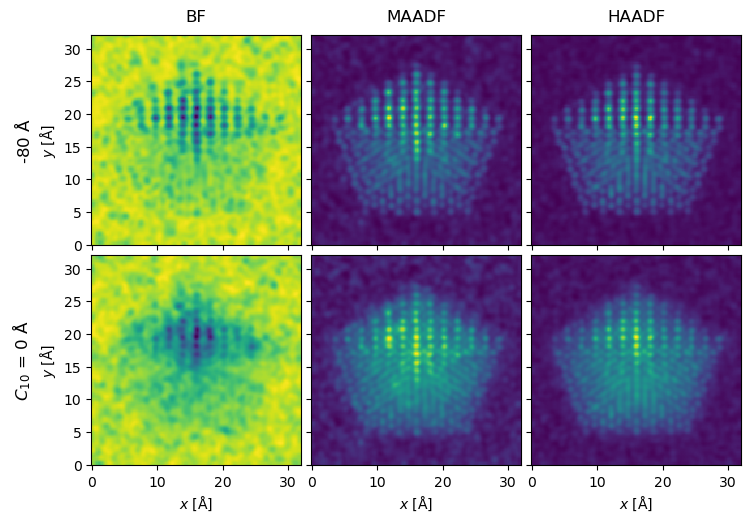

In [28]:
filtered_measurements = measurements.gaussian_filter(0.20).interpolate(0.2)

filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
);

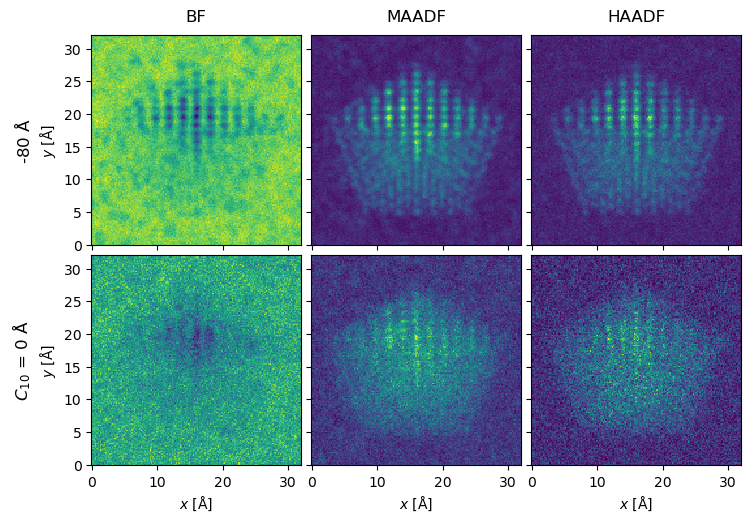

In [29]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=2e4)

noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    # cbar=True,
);

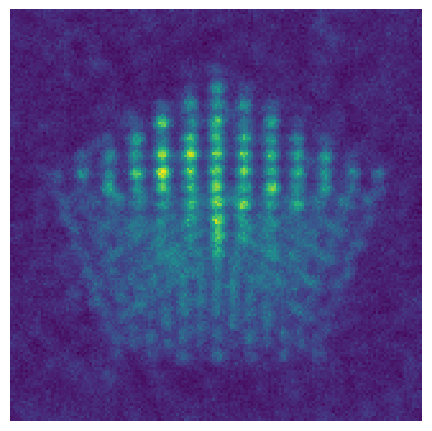

In [30]:
visualization = noisy_measurements[-2, -1].show()
visualization.axis_off()
plt.savefig("../thumbnails/prism_quickstart.png", bbox_inches="tight", pad_inches=0)